# Network Flows Lab

The goal of this lab is to gain some experience with applying network flows to existing problems. 

The following problem is adapted from [CSES 1711](https://cses.fi/problemset/task/1711):

Before beginning, the following cell contains any dependencies you may need for this assignment. 


In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ortools.graph.python import max_flow

*[Ortools](https://or-tools.github.io/docs/pdoc/ortools/graph/python/max_flow.html) is the library that we will be using to help solve the network flows problems.

## Background Info
A game consists of 6 rooms and 7 teleporters. At the beginning of the day, you start in room 0 and have to reach room 5. 

You can use each teleporter at most once during the game. How many days can you play if you choose your routes optimally?

The lines below represent the connections between the rooms. Each line has two integers: $a$ and $b$. There is a teleporter from room $a$ to room $b$.
0 1 \
0 2 \
1 5 \
2 3 \
2 4 \
3 5 \
4 5 \

## Questions
a. Determine the maximum number of days you can play the game. 
    2 days

b. Write out the route descriptions; this can be any valid solution.
    
    day 1: 0-1-5

    day 2: 0-2-3-4 or 0-2-4-5


## Graph Setup

First, let's set up our network flow problem in a format that's more familiar: nodes and edges. 

Each room represents a node and each teleporter represents an edge. Given that knowledge, fill out the `start_nodes` and `end_nodes` numpy arrays.

In [5]:
start_nodes = np.array([0,0,1,2,2,3,4]) # Replace with your code
end_nodes = np.array([1,2,5,3,4,5,5]) # Replace with your code

Now that we have populated our start and end nodes, we have to think about the capacities for each edge.

In this version of the problem, remember that each teleporter can only be used once.

In [6]:
capacities = np.array([1,1,1,1,1,1,1]) # Replace with your code

The cell below populates the information you have collected into a graph:

/var/folders/7p/56509rkj7kvbtmfr9nmjhvy00000gn/T/ipykernel_44209/2903003259.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g.add_edge(elrow[0], elrow[1], weight=elrow[2])


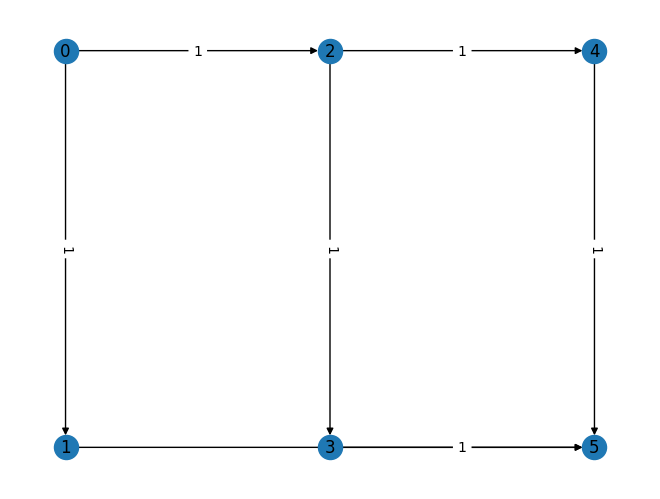

In [7]:
# Create an edgelist dataframe
edgelist_df = pd.DataFrame({'node1':start_nodes, 'node2':end_nodes,
                            'weights':capacities
                           })
edgelist_df

# Create a graph and add edges
g = nx.DiGraph()
for i, elrow in edgelist_df.iterrows():
    g.add_edge(elrow[0], elrow[1], weight=elrow[2])
g.edges(data=True)

# Add nodes to graph
g.add_node(0, pos=(0, 1))
g.add_node(1, pos=(0, 0))
g.add_node(2, pos=(1, 1))
g.add_node(3, pos=(1, 0))
g.add_node(4, pos=(2, 1))
g.add_node(5, pos=(2, 0))
g.nodes(data=True)

# Display graph
pos = nx.get_node_attributes(g,'pos')
weight = nx.get_edge_attributes(g,'weight') 
nx.draw(g,pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos,edge_labels = weight)
plt.show()

## A. Determine Maximum \# of Days You Can Play
The maximum # of days you can play the game can be represented by the maximum flow of the graph we just created. 

Since you can only use each teleporter once, each path taken cannot share edges. These are called **disjoint paths**. 

The maximum # of disjoint paths between two nodes is equal to the maximum flow according to the max flow min cut theorem we went over in class (NF Day 1).

In the following cell, use a simple max flow solver to calculate the maximum flow of the graph you created.

Helpful information: 
- Ortools documentation, including functions you will need, can be found [here](https://or-tools.github.io/docs/pdoc/ortools/graph/python/max_flow.html)
- An arc consists of a start node, an end node, and a capacity (or flow) from the start to the end node

In [11]:
# Instantiate a SimpleMaxFlow solver.
smf = max_flow.SimpleMaxFlow()

# Add arcs with capacities to the solver; this can be done either in bulk or one by one.
all_arcs = list(zip(start_nodes, end_nodes, capacities))


# Source & sink node; add in your code
source = 0
sink = 5

# Use simple max flow's solver & print your results
# Add arcs (edges) with capacities
for start, end, capacity in all_arcs:
    smf.add_arc_with_capacity(start, end, capacity)

# Compute max flow
if smf.solve(source, sink) == smf.OPTIMAL:
    max_flow_value = smf.optimal_flow()
    print(f"Maximum number of days you can play (max flow): {max_flow_value}")
else:
    print("There was an issue solving the max flow problem.")


Maximum number of days you can play (max flow): 2


## B. Route Descriptions
To ge the route descriptions, we need to extract the disjoint paths from our solution.

First, let's get the flow values for each arc: 

In [12]:
solution_flows = smf.flows(all_arcs)

Next, we need to identify the disjoint paths by checking the flow values. This can be done by traversing the graph starting from the source and following each path, keeping track of the arcs we've already used 

Start with a given node and iterate thorugh the graph until you have reached the final node. 

Helpful information:
- `smf.tail(arc)` should give a start_node
- `smf.head(arc)` should give a corresponding end_node
- You can add to a set with `set.add(item)`
- Remember to append to your path where you have visited!


In [13]:
used_arcs = set() # data structure to store used paths
def find_path(start_node):
    path = []
    # Iterate through the graph from the starting node to the sink
    # For each arc, check if there is a solution that is not in used_arcs
    # If there is, add the start and end nodes to the path & the arc itself to used arcs
    path = []
    visited = set()
    stack = [(start_node, [])]  # Stack to perform DFS (node, current path)

    while stack:
        node, curr_path = stack.pop()

        if node in visited:
            continue
        visited.add(node)
        
        # If we reach the sink, return the path
        if node == sink:
            path = curr_path
            break

        for neighbor in solution_flows.get(node, []):
            arc = (node, neighbor)  # Define the arc
            if arc not in used_arcs:  # Check if arc has been used
                stack.append((neighbor, curr_path + [arc]))  # Continue DFS

    # If a path is found, mark arcs as used
    if path:
        used_arcs.update(path)

    return path

You've calculated paths at this point, but now, you need to print your results. 
This is also a good way to check whether your results are logical. 

*Repeting nodes (ex 1 -> 2 -> 2 -> 3) is fine to represent 1 -> 2 -> 3.

In [14]:
disjoint_paths = []
# Iterate through the results of your optimal flow
# Add the path to disjointed_paths
flow_dict = {}  # Dictionary to store used edges
for i in range(smf.num_arcs()):
    start = smf.tail(i)
    end = smf.head(i)
    flow = smf.flow(i)

    if flow > 0:  # If flow is used, add it to the flow dictionary
        flow_dict.setdefault(start, []).append(end)

while True:
    path = []
    node = 0  # Start from the source (room 0)

    while node in flow_dict:
        next_nodes = flow_dict[node]
        if not next_nodes:
            break  # No more paths

        next_node = next_nodes.pop(0)  # Take the first available path
        path.append(node)
        node = next_node

    path.append(5)  # Add the sink (room 5) to the path

    if len(path) > 1:
        disjoint_paths.append(path)
    else:
        break
# Prints the paths
for path in disjoint_paths:
    print (" -> ".join(map(str, path)))

0 -> 1 -> 5
0 -> 2 -> 3 -> 5
